In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy
import anndata
import torch
from torch import tensor as tt
from sklearn.decomposition import PCA

from utils import *


# **Spatial fit**

In this notebook we try to fit some functions that describe the change  
in space of gene expression in the mice brain. Since it is bulk sequencing  
there are several cell typer which add variarion and might pollute our data

In [2]:
# immport the anndata file
adata = sc.read_h5ad("data/adata_hexagon.h5ad")
adata

AnnData object with n_obs × n_vars = 82 × 27462
    obs: 'x', 'y', 'z', 'counts'
    layers: 'log', 'norm'

In [3]:
zonated_genes = np.array(
    ["Vip", "Avp", "Prok2", "Penk", "Vipr2", "Avpr1a",  "Cck", "Grp", "Syt1"]
)


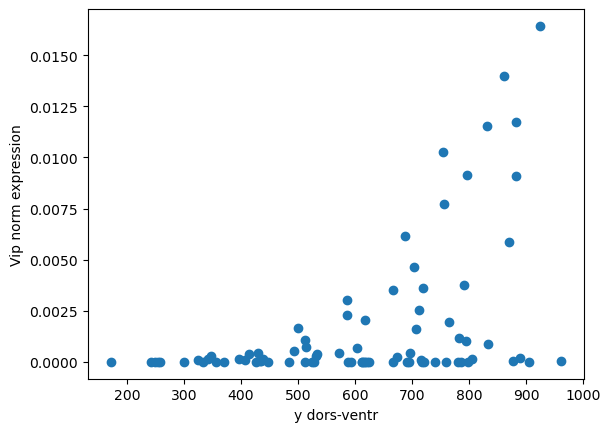

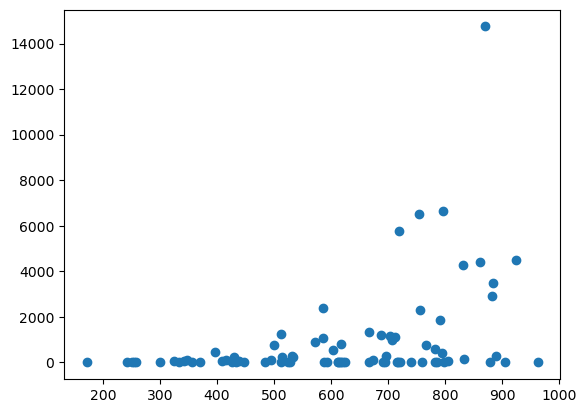

In [4]:
# plot Vip agaonst y coord
plt.scatter(adata.obs["y"], adata[:, "Vip"].layers["norm"])
plt.xlabel("y dors-ventr")
plt.ylabel("Vip norm expression")
# plt.yscale('log')
plt.show()
# now non noralied data
plt.scatter(adata.obs["y"], adata[:, "Vip"].X)

In [5]:
# create a matrix with x , y and z obs from adata, joining the 3 vectors as three columns
# and then convert it to a tensor

coord = np.stack((adata.obs["x"], adata.obs["y"], adata.obs["z"]), axis=-1)
# normalize the data
coord = (coord - coord.mean(axis=0)) / coord.std(axis=0)

xx = np.linspace(coord[:, 0].min(), coord[:, 0].max(), 1000)
yy = np.linspace(coord[:, 1].min(), coord[:, 1].max(), 1000)
zz = np.linspace(coord[:, 2].min(), coord[:, 2].max(), 1000)

# vector of variables used to plot
space = np.stack((xx, yy, zz), -1)
space

array([[-1.52578004, -2.30725508, -1.97932127],
       [-1.52205828, -2.30308561, -1.97523406],
       [-1.51833653, -2.29891614, -1.97114684],
       ...,
       [ 2.18480687,  1.84971023,  2.09563245],
       [ 2.18852862,  1.8538797 ,  2.09971967],
       [ 2.19225037,  1.85804918,  2.10380688]])

# torch model

In [6]:
# normalizing all 3 spatial positions

# coord  = tt(adata.obs['y'])
# coord = (coord - coord.mean())/coord.std()
# coord

In [7]:
# rescal lenghts bu a factor 100???

# defining non leaf vectors
# x = tt(coord.clone() )
# y = tt(adata[:,'Vip'].X)
# n_count = tt(adata.obs['counts'])

# # defining leaf vectors
# theta = tt([-6.75 , 1., -1000.])
# theta.requires_grad = True
# disp = tt(0.3, requires_grad=True)
# theta

In [8]:
def GLM_loss(x, y, n_count, theta, disp):
    NC = y.shape[0]

    a = -torch.exp(theta[2])
    lmbda = theta[0] + theta[1] * x + a * x**2
    lmbda = torch.exp(lmbda) * n_count

    alpha = torch.exp(disp)

    r = 1 / alpha
    p = alpha * lmbda / (1 + alpha * lmbda)
    NB = torch.distributions.NegativeBinomial(
        total_count=r, probs=p, validate_args=None
    )

    return -NB.log_prob(y).sum()


# GLM_loss(x, y, n_count, theta, disp)

In [9]:
# optimizer = torch.optim.Adam([theta, disp], lr=0.001)
# losses = []

# for step in range(10000):
#        optimizer.zero_grad()  # zero the gradients
#        output = GLM_loss(x, y, n_count, theta, disp)
#        output.backward()  # compute the gradients
#        optimizer.step()  # update the variable
#        losses.append(output.detach())

#        # print loss
# plt.plot(losses)
# plt.xlabel('iteration')
# plt.title(GLM_loss(x, y, n_count, theta, disp).detach().numpy())
# plt.show()


# Theta = theta.detach().numpy()
# xx = np.linspace(coord.min() , coord.max(), 1000)

# print(Theta)
# print(np.exp(disp.detach().numpy()))


# plt.scatter(coord , adata[:,'Vip'].layers['norm'], label = 'data')
# plt.plot(xx, parabola(xx, Theta), c = 'r', label = 'fit')
# plt.legend()
# plt.xlabel('y dors-ventr')
# plt.ylabel('Vip norm expression')
# plt.show()


# scipy model

In [10]:
# fit an exponential function to the data with scipy
# the x is coord and y is adata[:,'Vip'].layers['norm']

from scipy.optimize import curve_fit


def func(x, a, b):
    return np.exp(a * x + b)

Text(0, 0.5, 'Vip norm expression')

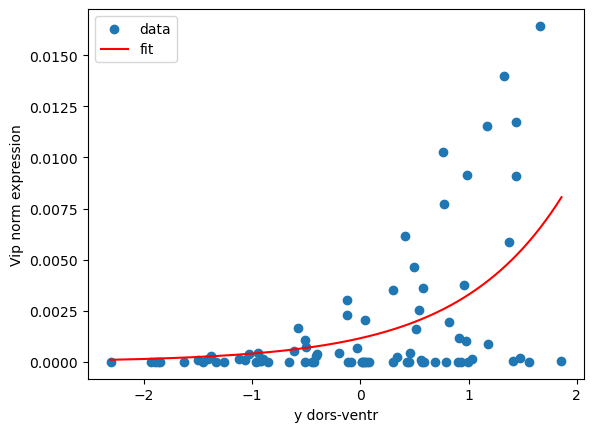

In [11]:
coef, _ = curve_fit(
    func, coord[:, 1], adata[:, "Vip"].layers["norm"].squeeze(), p0=(0, 0)
)

plt.scatter(coord[:, 1], adata[:, "Vip"].layers["norm"], label="data")
plt.plot(yy, func(yy, *coef), c="r", label="fit")
plt.legend()
plt.xlabel("y dors-ventr")
plt.ylabel("Vip norm expression")

## parabola fits

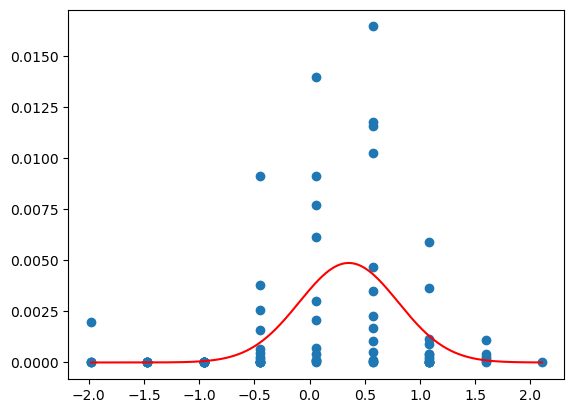

In [12]:
coef2, _ = curve_fit(
    func_2, coord[:, 2], adata[:, "Vip"].layers["norm"].squeeze(), p0=(0, 0, 0)
)

zz = np.linspace(coord[:, 2].min(), coord[:, 2].max(), 1000)

plt.scatter(coord[:, 2], adata[:, "Vip"].layers["norm"], label="data")
plt.plot(zz, func_2(zz, *coef2), c="r", label="fit")

loss_vip_z = np.sum(
    (adata[:, "Vip"].layers["norm"].squeeze() - func_2(coord[:, 2], *coef2)) ** 2
)


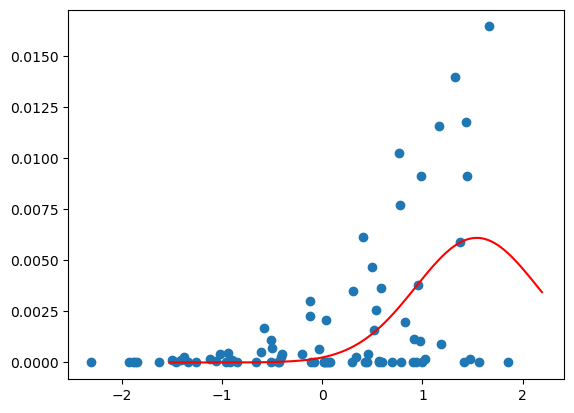

In [13]:
# same fit and plot but fitting vip

coef, _ = curve_fit(
    func_2, coord[:, 1], adata[:, "Vip"].layers["norm"].squeeze(), p0=(0, 0, 0)
)

plt.scatter(coord[:, 1], adata[:, "Vip"].layers["norm"], label="data")
plt.plot(xx, func_2(xx, *coef), c="r", label="fit")

# loss
loss_vip_y = np.sum(
    (adata[:, "Vip"].layers["norm"].squeeze() - func_2(coord[:, 1], *coef)) ** 2
)


In [14]:
space_labels = np.array(["med-lat", "dors-vent", "ant-post"])

# create a vector to store the fitted parameters
# N_genes x N_space_labels x N_parameters
theta = np.zeros((len(zonated_genes), 3, 3))
theta[0, 0, :]

array([0., 0., 0.])

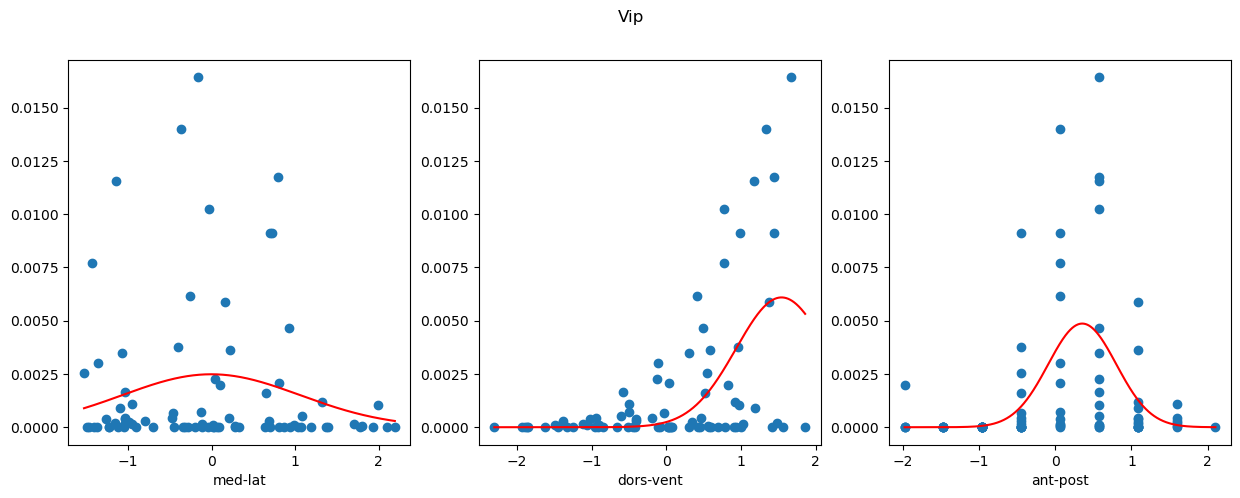

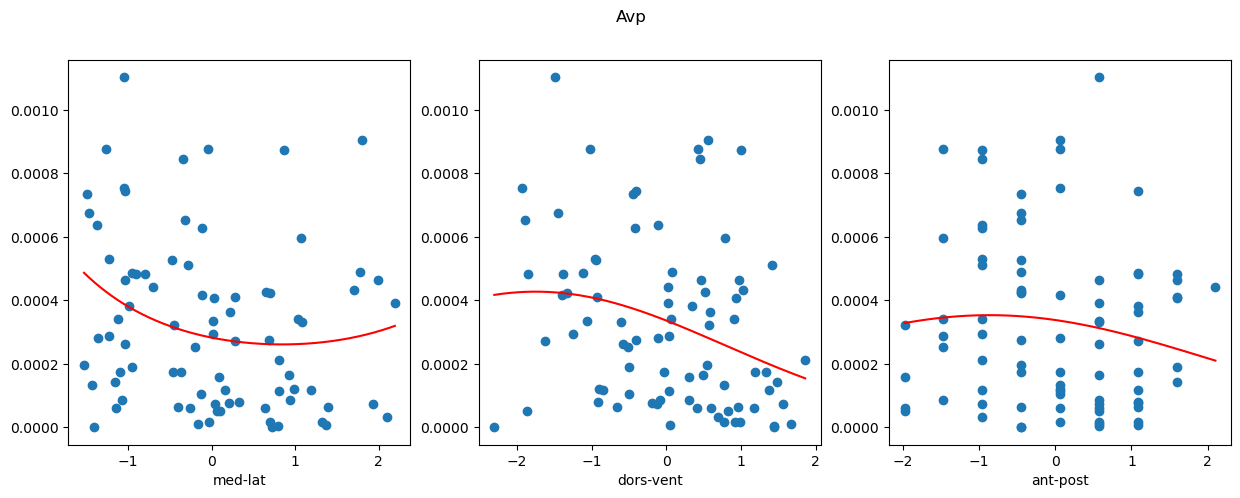

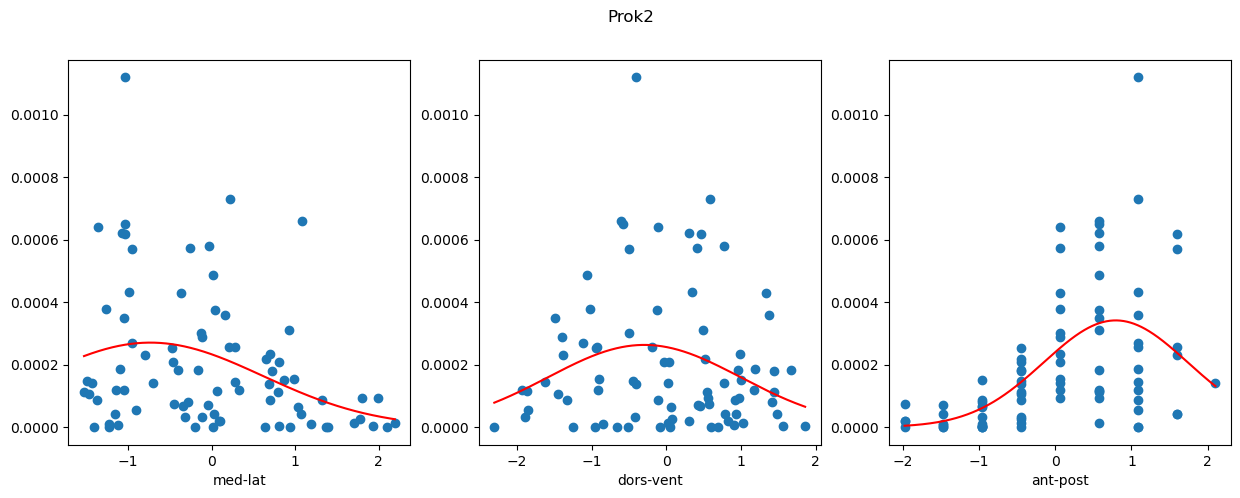

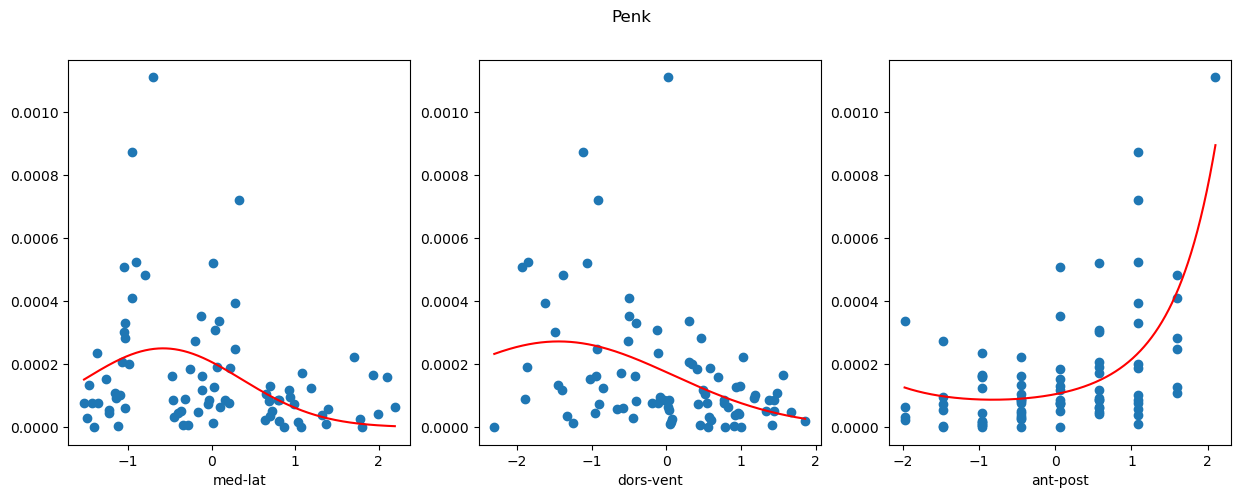

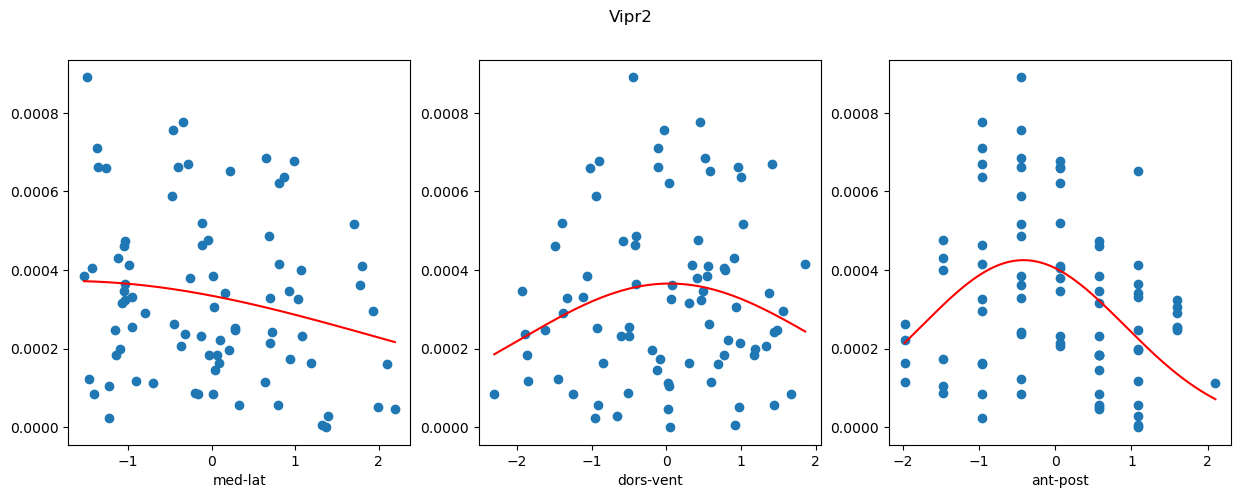

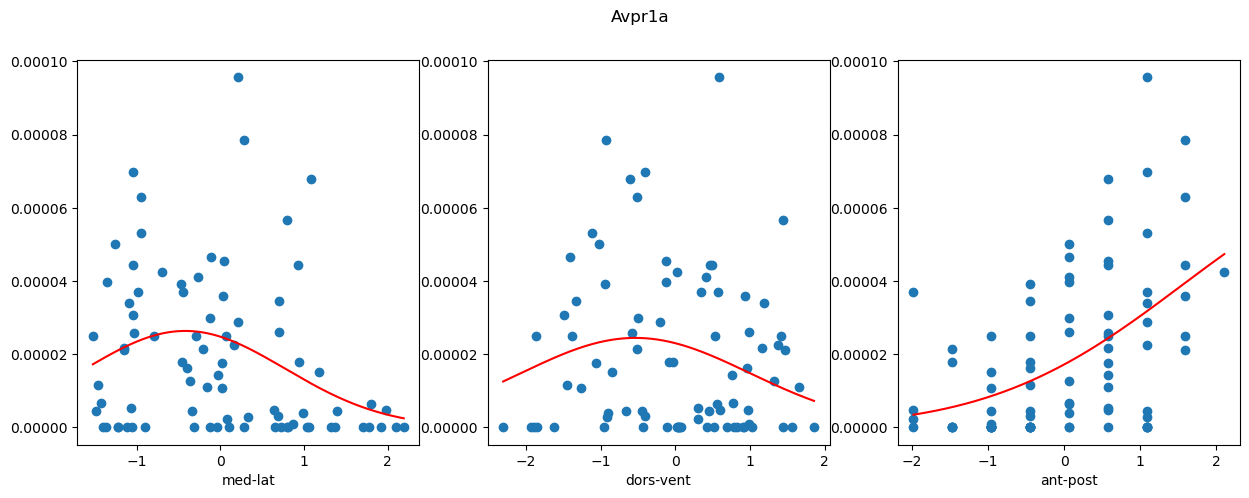

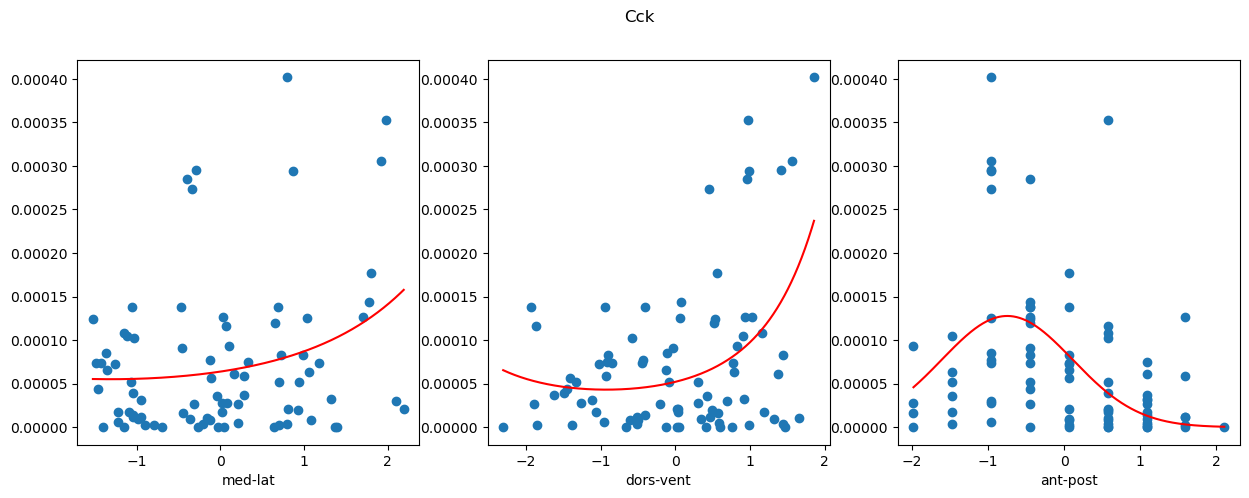

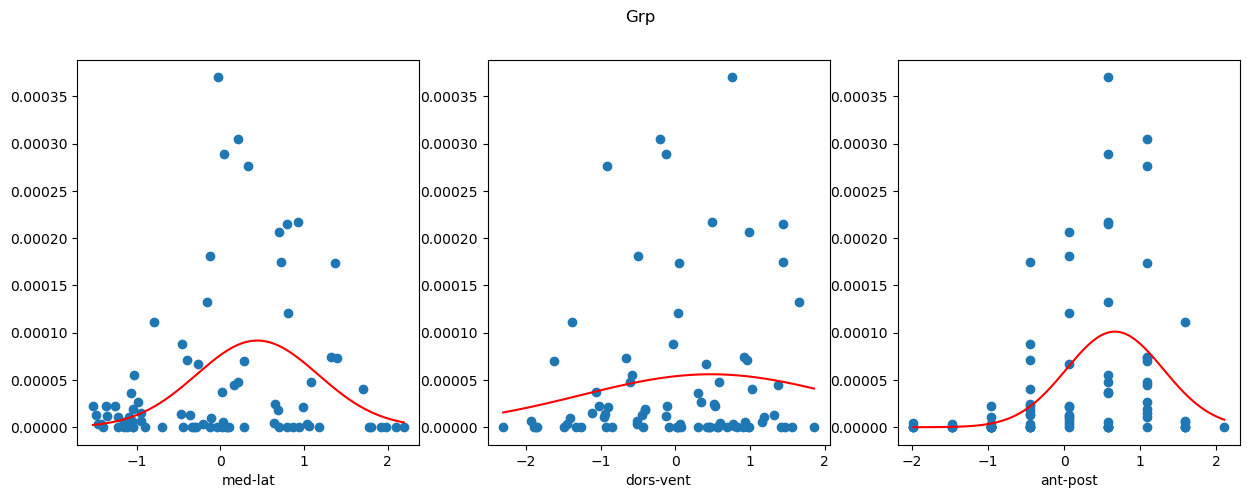

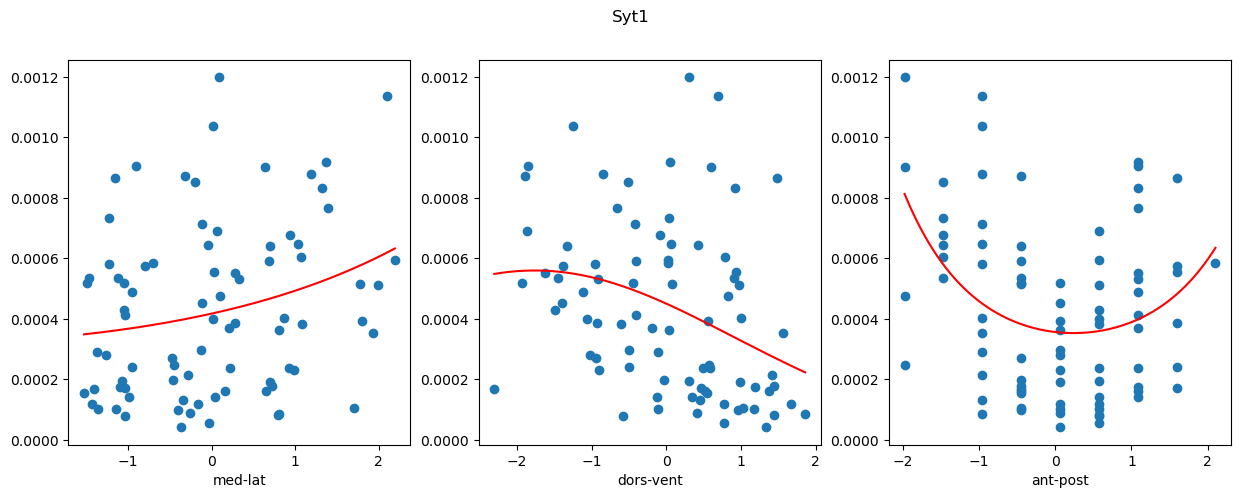

In [15]:
# now fit all the zonated genes, and plot the output of the fit
# for every gene plot the 3 dimensions side by side

for i, g in enumerate(zonated_genes):
    plt.figure(figsize=(15, 5))
    plt.suptitle(g)
    for d in range(3):
        theta[i, d, :], _ = curve_fit(
            func_2, coord[:, d], adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0)
        )
        plt.subplot(1, 3, d + 1)
        plt.scatter(coord[:, d], adata[:, g].layers["norm"], label="data")
        plt.plot(space[:, d], func_2(space[:, d], *theta[i, d, :]), c="r", label="fit")
        plt.xlabel(space_labels[d])
        # plt.yscale('log')

    plt.show()

now in the next phase I want to find new genes that are zonated in the same way as the known ones //
therefore I have two possibilities:
-  fit new genes in the same way and sort of capture the ones with the small zonated profiles based on the fitted parameters
-  correlation analysis: it's important to devide monotone genes from the ones with a peak. than look at monotone genes and peake one separately

In [16]:
print("       a                   b                  c")
theta[0, :, :]

# fixed theg ene and the dimension, caluclae x= -b / 2a , the position of the maximum/minimum
# if the position is outside the range of the data, then the probably a linear fit is better
# than print these values

for i, g in enumerate(zonated_genes):
    for d in range(3):
        print(g, space_labels[d], -theta[i, d, 1] / (2 * theta[i, d, 0]))

       a                   b                  c
Vip med-lat -0.004599094311432241
Vip dors-vent 1.541660533295475
Vip ant-post 0.3544080587539856
Avp med-lat 0.8434700444333686
Avp dors-vent -1.7534211445919574
Avp ant-post -0.8659560814147206
Prok2 med-lat -0.7326844146732343
Prok2 dors-vent -0.2972730408935418
Prok2 ant-post 0.7942089111572064
Penk med-lat -0.58028706978214
Penk dors-vent -1.4466178152943021
Penk ant-post -0.8186791140615262
Vipr2 med-lat -1.7432378064220535
Vipr2 dors-vent 0.04086518621942872
Vipr2 ant-post -0.4184017524458168
Avpr1a med-lat -0.4213344851870929
Avpr1a dors-vent -0.5353413004290005
Avpr1a ant-post 4.017005422857526
Cck med-lat -1.3118092132765924
Cck dors-vent -0.9281660264691628
Cck ant-post -0.74743443608552
Grp med-lat 0.44126595018690845
Grp dors-vent 0.4767255360476616
Grp ant-post 0.6658935680879375
Syt1 med-lat -3.788652638164564
Syt1 dors-vent -1.7657825099355433
Syt1 ant-post 0.24113779597976698


# 3D spatial fit

Now we will use the following model:  

**2D**  
we start from Vip which is mainly zonated in directions only. acutally for vip the dims are y and z.  
in the end we want somethig: 
\begin{equation}
    \mu_i = exp( a_x x_i^2 + b_x x_i+ b_y y_i^2  +b_y y_i + c )  
\end{equation}

**3D**  
in the end we want: 
\begin{equation}
    \mu_i = exp( a_x x_i^2 + b_x x_i+ b_y y_i^2  +b_y y_i + b_z z_i^2  +b_z z_i + c )  
\end{equation}

## experimenting with Vip

In [17]:
# fit all the genes
yz = coord[:, [1, 2]]
theta_2D = np.zeros((len(zonated_genes), 5))
losses_2D = np.zeros(len(zonated_genes))
for i, g in enumerate(zonated_genes):
    theta_2D[i, :], _ = curve_fit(
        func_2D, yz.T, adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0, 0, 0)
    )
    # loss
    losses_2D[i] = loss_2D(
        coord[:, [1, 2]], adata[:, g].layers["norm"], *theta_2D[i, :]
    )


In [18]:
# np.where(adata.var == 'Vip')
adata.var.index.get_loc("Vip")


14804

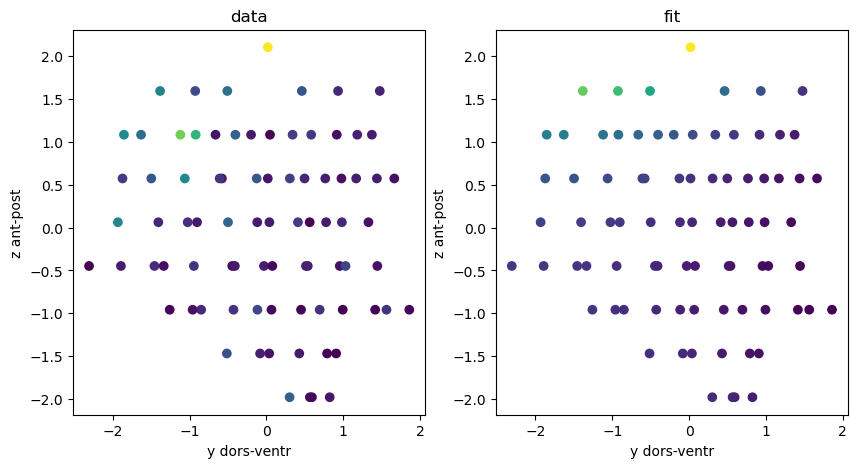

In [19]:
# fit the 2D function to the data
gene = "Penk"

# plot the fit SIDE BY SIDE with the data
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(yz[:, 0], yz[:, 1], c=adata[:, gene].layers["norm"].squeeze())
plt.title("data")
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")

plt.subplot(1, 2, 2)
plt.scatter(
    yz[:, 0], yz[:, 1], c=func_2D(yz.T, *theta_2D[ind_z(zonated_genes, gene), :])
)
plt.title("fit")
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")
plt.show()

In [20]:
# fit 3D model to vip counts
xyz = coord[:, [0, 1, 2]]

# fit
coef, _ = curve_fit(
    func_3D, xyz.T, adata[:, "Vip"].layers["norm"].squeeze(), p0=(0, 0, 0, 0, 0, 0, 0)
)

# loss
Y_hat = func_3D(xyz.T, *coef)
loss_vip_3D = np.sum((adata[:, "Vip"].layers["norm"].squeeze() - Y_hat) ** 2)
coef


array([-0.32194743, -0.15893787, -0.49823985,  1.86412033, -1.90738963,
        1.07369843, -5.81855123])

Loss functions get definetly smaller

In [21]:
print(
    "loss 3D ",
    loss_vip_3D,
    "loss only y ",
    loss_vip_y,
    "loss only z ",
    loss_vip_z,
)


loss 3D  5.9022474146021875e-05 loss only y  0.0006947759689121867 loss only z  0.000760305986528579


In [22]:
# fitting all zonated genes in 3D
# create a vector to store the fitted parameters
# N_genes x  N_parameters
theta = np.zeros((len(zonated_genes), 7))
# save losses
losses = np.zeros(len(zonated_genes))
print(theta.shape)
# now fit all the zonated genes
for i, g in enumerate(zonated_genes):
    theta[i, :], _ = curve_fit(
        func_3D, xyz.T, adata[:, g].layers["norm"].squeeze(), p0=(0, 0, 0, 0, 0, 0, 0)
    )
    losses[i] = loss_3D(xyz, adata[:, g].layers["norm"].squeeze(), *theta[i, :])


(9, 7)


In [23]:
# print side by side the losses andthe gene name
for i, g in enumerate(zonated_genes):
    print(g, losses[i])

Vip 5.9022474146021875e-05
Avp 4.72468576218204e-06
Prok2 1.3077464988839732e-06
Penk 1.223944325998394e-06
Vipr2 2.426210121365195e-06
Avpr1a 2.2771416130431827e-08
Cck 3.4432741198430156e-07
Grp 1.8667461337193187e-07
Syt1 3.024364595826676e-06


# Single Cell

## loading data 

In [61]:
# load dataset
scData = pd.read_csv("data/190923_Neuron_1.csv")
scData = scData.T
col_names = scData.iloc[0, :].values
# delete first row

scData = scData.drop(scData.index[0])
scData.columns = col_names
scData["Vip"].mean()

# create anndata object
E_sc = anndata.AnnData(scData)
E_sc.X = E_sc.X.astype(float)


In [62]:
# remove columns/genes with all zeros
E_sc = E_sc[:, E_sc.X.sum(axis=0) != 0]
# normalize per cell
E_sc.layers["norm"] = E_sc.X / E_sc.X.sum(axis=1).reshape(-1, 1)
# now standardize the data
E_sc.layers["stand"] = (
    E_sc.layers["norm"] - E_sc.layers["norm"].mean(axis=0)
) / E_sc.layers["norm"].std(axis=0)
E_sc.obs['counts'] = E_sc.X.sum(axis=1)

In [63]:
sc_zon = zonated_genes[zonated_genes != "Prokr2"]
sc_small = E_sc[:, sc_zon]

NC, NG = sc_small.shape

In [64]:
sc_small.layers["norm"].astype(float)
corr_cells = np.corrcoef(sc_small.layers["norm"].astype(float))
corr_genes = np.corrcoef(sc_small.layers["norm"].astype(float).T)


/Users/salati/miniforge3/envs/pyro/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/salati/miniforge3/envs/pyro/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [65]:
# # set the diagonal to 0
# np.fill_diagonal(corr_genes, 0)

# # plott correlation matrix, plot the names of the genes on the axis and the colorbar
# plt.imshow(corr_genes, cmap="bwr", vmin=-1, vmax=1)
# plt.colorbar()
# plt.xticks(np.arange(len(sc_zon)), sc_zon, rotation=90)
# plt.yticks(np.arange(len(sc_zon)), sc_zon)
# plt.show()


## finding seed values for x,y,z

In [66]:
E_sc.layers["norm"].astype(float).shape


(3473, 10938)

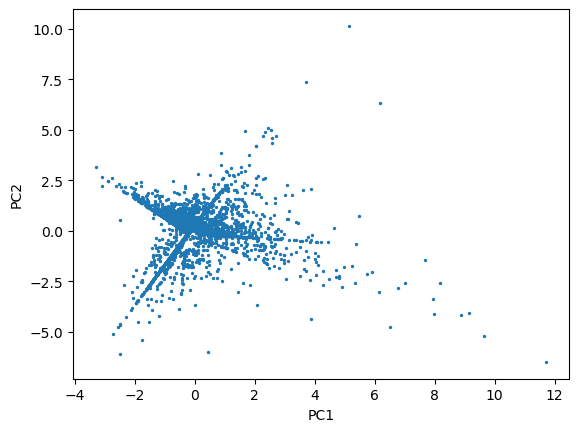

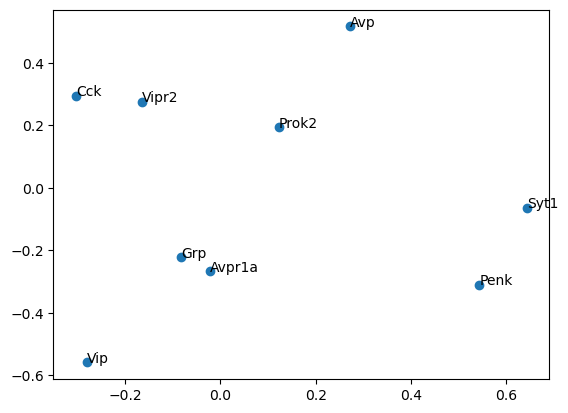

In [67]:
# perform PCA and plot the first 2 components
pca = PCA(n_components=2)
PC = pca.fit_transform(sc_small.layers["stand"])
vec = pca.components_

# plot the first 2 components
plt.scatter(PC[:, 0], PC[:, 1], s=2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# plot the loadings of the first 2 components
plt.scatter(vec[0, :], vec[1, :])
# now annotate with gene names
for i, g in enumerate(sc_zon):
    plt.annotate(g, (vec[0, i], vec[1, i]))


In [68]:
# print mean, and variance for the normalized cut of every gene, next to the gene name
for i, g in enumerate(sc_zon):
    print(g, sc_small[:, g].layers["norm"].mean(), sc_small[:, g].layers["norm"].var())


Vip 0.003625200484753833 0.00010614709775601193
Avp 0.004861041735036458 0.00015591187371069017
Prok2 5.74166786022145e-05 1.6045260386920854e-07
Penk 0.00018533432754194251 7.936764411158158e-07
Vipr2 0.0004675131786080841 8.467074118142343e-07
Avpr1a 3.609996935359791e-05 6.406688290133617e-08
Cck 0.0007952586282860812 5.903915061976424e-06
Grp 6.119726961312588e-05 2.843915299569346e-07
Syt1 0.0004975742736153336 1.2332296147827505e-06


## trying to order cells

In [69]:
order_z = np.argsort(np.argsort(sc_small[:, "Penk"].layers["norm"]))
np.argsort(sc_small[:, "Penk"].layers["norm"].squeeze()).sum()

ArrayView(6029128)

In [70]:
# now take gene Penk and get the argsort. This will give the order of the cells
# after standardize this position vecotr

# get the order of the cells
order_z = np.argsort(np.argsort(sc_small[:, "Penk"].layers["norm"]).squeeze())
z_guess = (order_z - order_z.mean()) / order_z.std()
order_z

# do the same for gene Vip
order_y = np.argsort(np.argsort(sc_small[:, "Vip"].layers["norm"]).squeeze())
y_guess = (order_y - order_y.mean()) / order_y.std()
order_y


ArrayView([   0, 2308, 2309, ..., 1163, 1152, 3472])

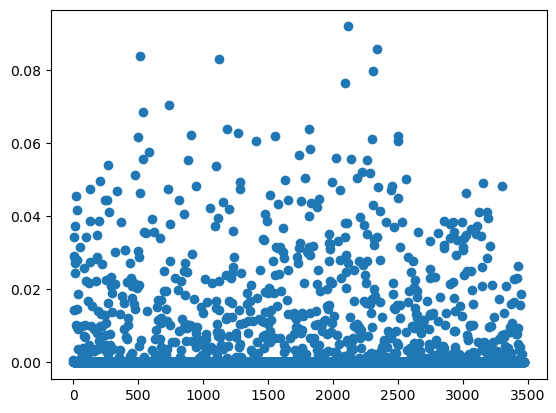

In [71]:
# plt.scatter(np.linspace(0 , 1, NC), sc_small[:, 'Penk'].layers['norm'])
plt.scatter(order_y, sc_small[:, "Vip"].layers["norm"])


## torch model for space recon

In [72]:
X = np.stack((y_guess, z_guess), axis=-1)
print(X.shape)
X = tt(X, requires_grad=True)

theta2 = tt(theta_2D)
print(theta2.shape)

(3473, 2)
torch.Size([9, 5])


In [73]:
# convert onated dataset to tesor
Y = tt(sc_small[:, :].layers["norm"])
Y_counts = tt(sc_small[:, :].X)
disp = tt(0.3, requires_grad=True)

dimension of tensor :
- X = NC x N_dim  
- theta = Ng x Nparam

In [86]:
sc_counts = tt(E_sc.obs["counts"].values, dtype=torch.float32)

In [88]:
def model_2D(X, Y, theta):
    """
    model that given the expressiony and the parameters theta
    returns the expected value of the expression. To do so it needs to
    optimize the position-parameter x. Than we un least square loss to fit the model
    """
    NC = Y.shape[0]

    lmbda = (
        theta[:, 0][None, :] * X[:, 0][:, None] ** 2
        + theta[:, 1][None, :] * X[:, 0][:, None]
        + theta[:, 2][None, :] * X[:, 1][:, None] ** 2
        + theta[:, 3][None, :] * X[:, 1][:, None]
        + theta[:, 4][None, :]
    )
    lmbda = torch.exp(lmbda)

    loss = torch.sum((Y - lmbda)**2)
    return loss

def model_2D_NB(X, Y, theta, n_count, disp):
    """
    model that given the expressiony and the parameters theta
    returns the expected value of the expression. To do so it needs to
    optimize the position-parameter x. Than we un least square loss to fit the model
    """
    NC = Y.shape[0]

    lmbda = (
        theta[:, 0][None, :] * X[:, 0][:, None] ** 2
        + theta[:, 1][None, :] * X[:, 0][:, None]
        + theta[:, 2][None, :] * X[:, 1][:, None] ** 2
        + theta[:, 3][None, :] * X[:, 1][:, None]
        + theta[:, 4][None, :]
    )
    lmbda = torch.exp(lmbda) * n_count[:, None]
    alpha = torch.exp(disp)

    r = 1 / alpha
    p = alpha * lmbda / (1 + alpha * lmbda)

    NB = torch.distributions.NegativeBinomial(
        total_count=r, probs=p, validate_args=None
    )

    return -NB.log_prob(Y).sum()

model_2D_NB(X, Y_counts, theta2, sc_counts, disp)

tensor(62175.9627, dtype=torch.float64, grad_fn=<NegBackward0>)

In [90]:
# train model

#optimizer = torch.optim.Adam([X], lr=0.001)
optimizer = torch.optim.Adam([X, disp], lr=0.001)
losses = []

for step in range(10000):
    optimizer.zero_grad()  # zero the gradients
    # output = model_2D(X, Y, theta2)
    output = model_2D_NB(X, Y_counts, theta2, sc_counts, disp)
    output.backward()  # compute the gradients
    optimizer.step()  # update the variable
    losses.append(output.detach())

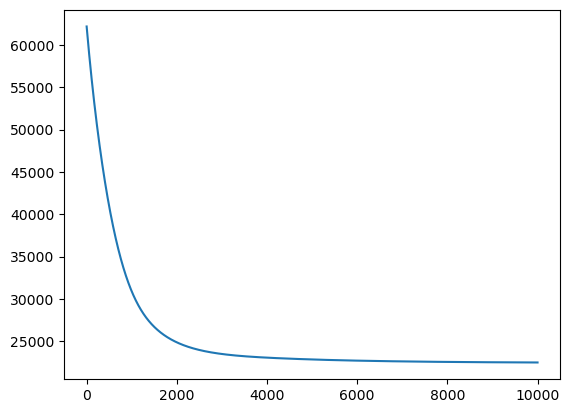

In [91]:
plt.plot(losses[0000:])

Text(0.5, 0, 'y dors-ventr')

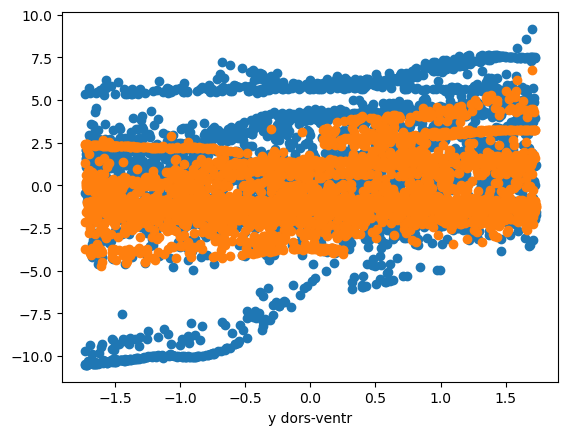

In [92]:
x_train = X.clone().detach().numpy()


plt.scatter(y_guess, x_train[:, 0])
plt.scatter(z_guess, x_train[:, 1])
plt.xlabel("y dors-ventr")

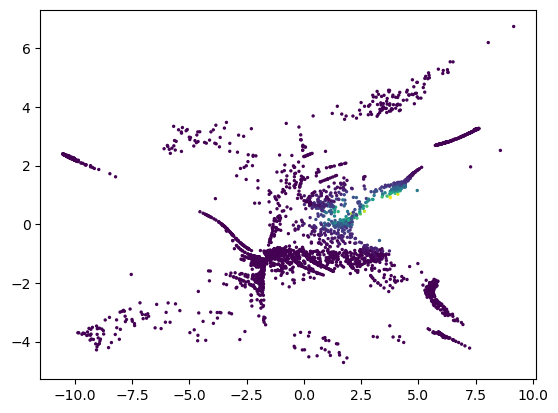

In [93]:
plt.scatter(x_train[:, 0], x_train[:, 1], c = sc_small[:, 'Vip'].layers['norm'].squeeze(), s=2)

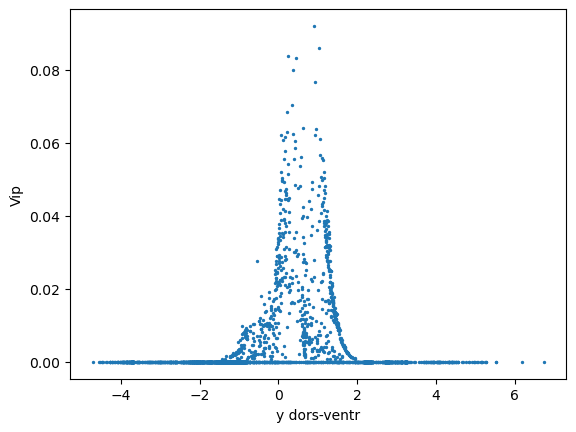

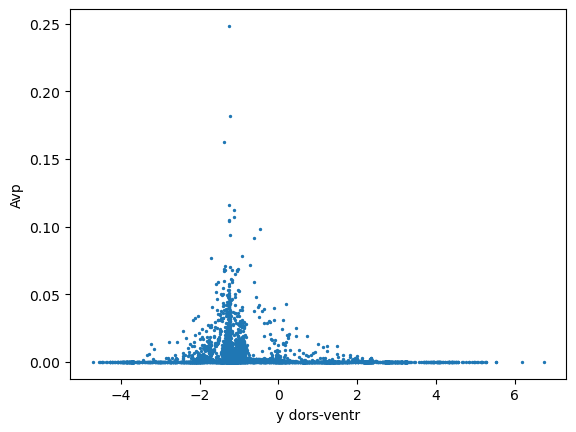

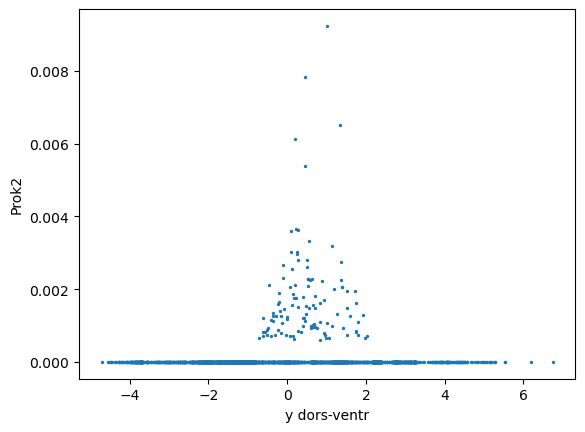

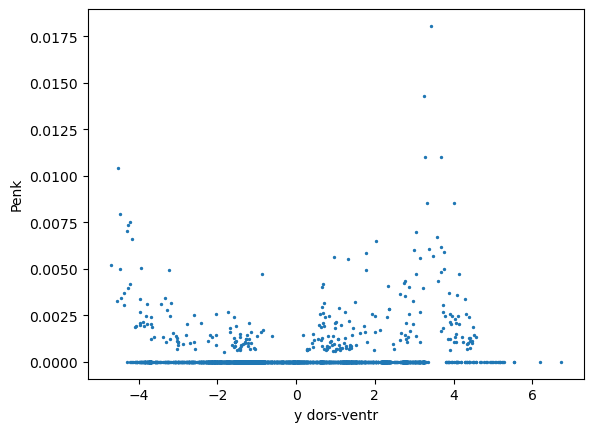

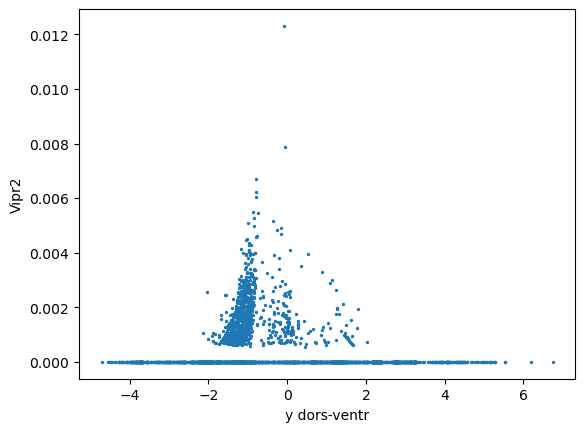

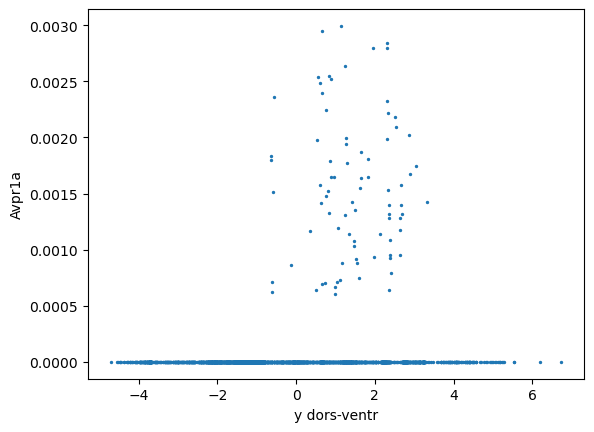

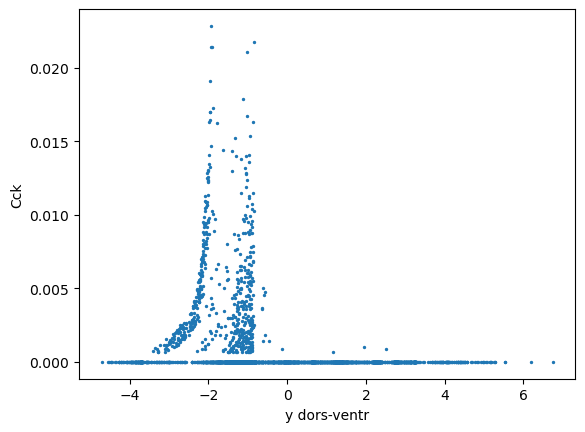

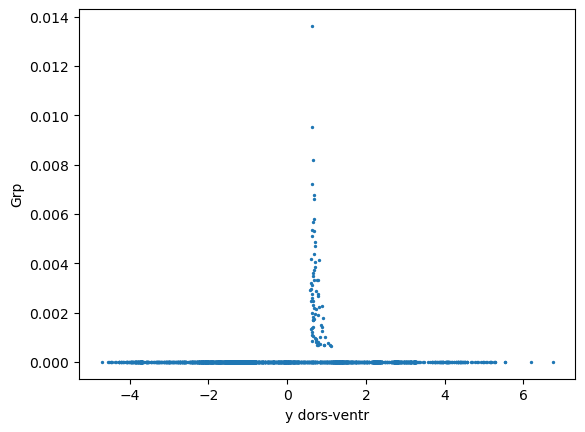

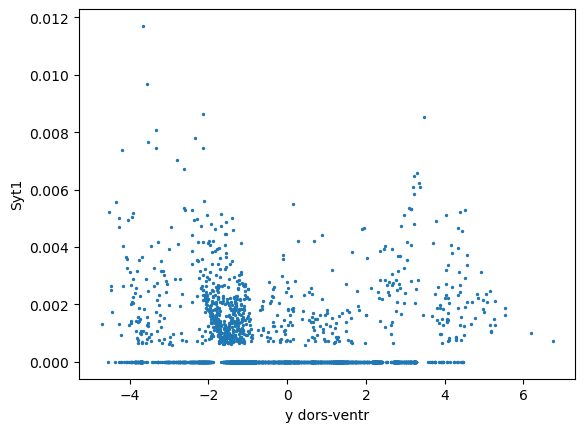

In [94]:
# plot the new x with expression of all zonated genes

for i, g in enumerate(sc_zon):
    plt.scatter(x_train[:, 1], sc_small[:, g].layers["norm"], s = 2)
    plt.xlabel("y dors-ventr")
    plt.ylabel(g)
    plt.show()